# Time Ordered Exponential and Floquet Expansion
In this notebook, we compute the time ordered exponential of a harmonically driven Hamiltonian of a 2-level system. The Hamiltonian is:

$$
 H(t) = \frac{1}{2} E_0 Z + \frac{1}{2} V_0 \sin(\omega t)X
$$

We apply the Trotter-Suzuki formula with time step $\delta t$. In its simplest form, the formula replaces $H(t)$ by a piecewise constant function that remains constant in time intervals $[t,t+\delta t]$ at its value at the beginning of the interval. Therefore, the unitary evolution operator to propagate the quantum state from time $t$ to time $t+\delta t$ is,

$$
U_{\delta t}(t)\equiv\exp{\left[-i \frac{\delta t}{\hbar} H(t)\right]} = I \cos(\Omega(t)\delta t) - i \left[E_0 Z + V_0 \sin(\omega t) X\right] \frac{\sin(\Omega(t)\delta t)}{2 \Omega(t)},
$$

where we have defined,

$$
\Omega(t) = \frac{1}{2\hbar}\sqrt{E_0^2 + V_0^2 \sin^2(\omega t)}.
$$

The time-ordered evolution operator between time $t_0$ and $t$ is,

$$
\mathcal{T} \exp{\left[\frac{-i}{\hbar}\int_{t_0}^{t} H(t')dt'\right]} = U_{\delta t}(t-\delta t)\cdots U_{\delta t}(t_0+2\delta t)U_{\delta t}(t_0+\delta t)U_{\delta t}(t_0).
$$

To propagate a quantum state from initial value $\psi(t_0)$ to an arbitrary time $\psi(t)$ later, the above formula gives the recurrence relation,

$$
\psi(t = t_0) = \psi_0,
$$

$$
\psi(t + \delta t) = U_{\delta t}(t) \psi(t).
$$

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import signal
from math import pi
from matplotlib import pyplot as plt

Below we implement 3 functions to realize the time-ordered exponentials above.

In [7]:
# We will use time in energy units so that hbar=1
# Pauli Z matrix
Z = np.array([[1,0],[0,-1]])
# Pauli X matrix
X = np.array([[0,1],[1, 0]])

def Hamiltonian(t, E0, V0, omega):
    """Implements the Hamiltonian function H(t) above
    """
    H = E0/2 * Z + V0 / 2 * np.sin(omega*t) * X
    return H

def Omega(t, E0, V0, omega):
    return 1/2 * np.sqrt( E0**2 + V0**2 * np.sin(omega*t)**2 )

def UnitaryStep(dt, t, E0, V0, omega):
    """Implements the single step for unitary evolution, U_{delta t}(t) above.
    """
    W = Omega(t,E0,V0,omega)
    H = Hamiltonian(t,E0,V0,omega)
    U = np.cos(W*dt)*np.eye(2) - 1j* np.sin(W*dt)/ W * H
    return U
    
def PropagateState(psi0, tmax, E0, V0, omega, dt):
    """Implements the evolution of initial state to final state as shown in the last equation in the introduction.
    """
    t = np.arange(0, tmax, dt)
    psi = np.zeros((len(t), 2),dtype=complex)
    psi[0] = psi0
    for i in range(1,len(t)):
        U1 = UnitaryStep(t[i]-t[i-1], t[i-1], E0, V0, omega)
        psi[i] = U1 @ psi[i-1]
    return psi, t

The next three functions implement the substitution of

In [33]:
def dpsidt(t , psi, E0, V0, omega):
    H = Hamiltonian(t,E0, V0, omega)
    dy = -1j * (H @ psi)
    return dy

def EvalResidual(t, psi, E0, V0, omega):
    dydt = np.gradient(psi, t[1]-t[0], axis=0)
    rhs = np.array([-1j*Hamiltonian(t[i],E0, V0, omega) @ psi[i] for i in range(len(t))])
    res = (np.abs(dydt-rhs)**2).sum(axis=1)
    return res

(1000, 2)


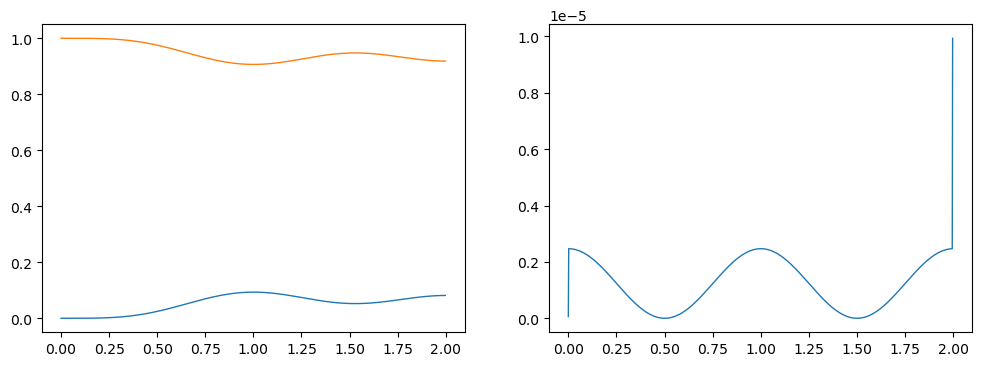

In [34]:
T = 2
params = E0, V0, omega = 1, 1, 2*pi/T
Wmax = Omega(T/4, *params)
dt = min(T/1000, 2*np.pi/Wmax/4000)
psi0 = np.array([0,1],dtype=complex)

psi, t = PropagateState(psi0, T, *params, dt)
print(psi.shape)
f = np.abs(psi)**2
residual = EvalResidual(t, psi, *params)
fig,axs=plt.subplots(ncols=2,figsize=(12,4))
axs[0].plot(t, f, linewidth=1)
axs[1].plot(t, np.abs(residual), linewidth=1)


In [28]:
psi.shape

(1000, 2)